<a href="https://colab.research.google.com/github/roeelq323/Anime-Rating-Project/blob/main/Anime_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports:**
---
Here we are installing all the packages needed for the project
and importing them.

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install fake-useragent
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from fake_useragent import UserAgent


In [127]:
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as scD
import numpy as np
from lxml import etree
import json
import random
import time
import bs4
import requests
from ast import literal_eval
import re
from google.colab import drive #taking files from google drive
drive.mount('/content/drive')
import sklearn
from sklearn import preprocessing 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Scraping the data:**
---
In order to scrape the the data from the MAL (my anime list) website we tried at first using only request and beautiful soup and discovered that the website uses javascript to load the anime charts , so using request would'nt help us. 
we decided to use selenium who a opens a browser driver and then loads websites based on the url given. using selenium we got all the data that was missing in the chart.

#open_driver:
This function opens the selenium driver at the given url. In order to not be blocked by the MAL website (that happend a couple of times) we needed to use a method so the website would'nt recognize the driver as a bot and block it.
At first we used a diffrent user agent for every request. We used the fake_useragent package that gives random user agents every time its called.
Then we put random intervals between requests (between 5 to 10 seconds)
so that website wont crash from request overload, and the driver won't be blocked.

In [ ]:

def open_driver(url): #opening the chrome driver in order to get html:
  ua = UserAgent()
  userAgent = ua.random
  options = Options()
  options.add_argument(f'user-agent={userAgent}')
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')#google colab settings
  options.add_argument('--no-sandbox')#google colab settings
  options.add_argument('--disable-dev-shm-usage')#google colab settings
  driver = webdriver.Chrome('chromedriver',options=options)
  time.sleep(random.randint(5,10))
  driver.get(url)

  return driver

#get_html:
Gives the HTML documentation of the page that the given driver is on.
this function uses another precaution and deletes the driver cookies so that the website would'nt be able to track it and block it.

In [ ]:
def get_html(driver):
  soup = BeautifulSoup(driver.page_source, 'lxml')
  driver.delete_all_cookies()
  return soup

#Making list of URls:
---
In order to make the scraping easier and more organized we decided on making a list of URLs, so that when we scrape we'll be able to find which anime has missing data and what is missing. each url is an anime page with the info we need.

#get_page_var:
Gives a list of names and URLs of the 50 anime in the HTML given to the function.


In [ ]:
def get_page_var(soup , names , urls):
  next_url = "https://myanimelist.net/topanime.php" + soup.find("a" , attrs = {"class":"link-blue-box next"}).get("href")
  table = soup.find_all("div" , attrs = {"class":"di-ib clearfix"})
  for row in table:
    names.append(row.find("a").get_text())
    urls.append(row.find("a").get("href"))
  return names,urls,next_url


#Building URL dataframe:
Here we are creating the url dataframe by appending arrays and saving it as a csv file.

In [ ]:
#creating url and name dataframe:
name_arr = []
url_arr = []
moving_url = "https://myanimelist.net/topanime.php?type=bypopularity&limit=0"
for i in range(65):
  driver = open_driver(moving_url)
  soup = get_html(driver)
  name_arr,url_arr,moving_url = get_page_var(soup , name_arr , url_arr)
  driver.quit()

df_url = pd.DataFrame({"Anime name" : name_arr , "URL" : url_arr })
df_url.to_csv("anime_url_list.csv")


#anime_variables:
This function returns a dataframe with all the parameters on the anime in the given url.

The first problem we encountered is the information changing positions. each parmeter has the same class in the HTML file so at first we tried to numerate the paramenters in an array and get them based on index. That didn't work because every anime has the parameters lined in diffrent orders. So to fix the problem we made an array of the parameter names and then found each one based on its name.

The second problem we had is with missing values, that could'nt be found so while running on the URL list every anime that had missing value we added a try and except to it so that it would give it a "nan" value and won't crash.


In [ ]:
def anime_variables(url):
  arr=[]
  driver = open_driver(url)
  soup = get_html(driver)
  info = soup.find_all("div" , attrs = {"class":"spaceit_pad"})
  for i in info:
    try:
      arr.append(i.find("span" , attrs= {"class":"dark_text"}).get_text())#creating an array of parameter names.
    except:
      arr.append("null")

  name = soup.find("h1" , attrs = {"class":"title-name h1_bold_none"}).get_text()
#finding the right index of every paramenter in the website and getting its value
  try:
    anime_type= info[arr.index("Type:")].find("a").get_text()
  except:
    anime_type = "nan"

  episodes= info[arr.index("Episodes:")].find_all(text=True, recursive=False)[-1].strip()

  try:
    premiered= info[arr.index("Premiered:")].find("a").get_text()
  except:
    premiered = "nan"     
  licensors=[i.get_text() for i in info[arr.index('Licensors:')].find_all("a")]
  studios = [i.get_text() for i in info[arr.index('Studios:')].find_all("a")]
  source= info[arr.index('Source:')].find_all(text=True, recursive=False)[-1].strip()

  try:
    if 'Genres:' in arr:
      genres= [i.get_text() for i in info[arr.index('Genres:')].find_all("a")]
    else:
      genres= [i.get_text() for i in info[arr.index('Genre:')].find_all("a")]
  except:
    genres= "nan"

  try:
    if "Themes:" in arr:
      theme= [i.get_text() for i in info[arr.index('Themes:')].find_all("a")]
    else:
      theme= [i.get_text() for i in info[arr.index('Theme:')].find_all("a")]
  except:
    theme = "nan"

  try:
    demographic= info[arr.index('Demographic:')].find("a").get_text()
  except:
    demographic= "nan"

  duration= info[arr.index('Duration:')].find_all(text=True, recursive=False)[-1].strip()
  age_rating= info[arr.index('Rating:')].find_all(text=True, recursive=False)[-1].strip()
  members= info[arr.index('Members:')].find_all(text=True, recursive=False)[-1].strip()
  favorites= info[arr.index('Favorites:')].find_all(text=True, recursive=False)[-1].strip()
  try:
    user_rating= info[arr.index('Score:')].find("span" , attrs = {"itemprop":"ratingValue"}).get_text()
  except:
    user_rating = "nan"
  
  try:
    num_ratings= info[arr.index('Score:')].find("span" , attrs = {"itemprop":"ratingCount"}).get_text()
  except:
    num_ratings = "nan"

  data = pd.DataFrame({"Anime name":[name],"Type":[anime_type],"Episodes":[episodes],"Premiered":[premiered],"Licensors":[licensors],"Studios":[studios],"Source":[source],
                       "Genres":[genres],"Themes":[theme],"Demographic":[demographic],"Duration":[duration],"Age rating":[age_rating],"Added to list members":[members],"Added to favorites members":[favorites],
                       "Rating":[user_rating],"Members that voted":[num_ratings]})
  
  return data

#Building the anime dataframe:
---
Adding all the data together making the dataframe we'll be working on. In order to make the scraping process not go to waste each time the scraping is failing or crashing for any reason the dataframe is saved as csv file and each time the function is running it starts from where it left off.

In [ ]:
#creating the final dataframe:
url_df = pd.read_csv("anime_url_list.csv")
try:#if a dataframe exists open it
  df_final = pd.read_csv("anime_dataframe.csv")
except:#if it dosent exist create an empty one
  df_final = pd.DataFrame(columns = ["Anime name","Type","Episodes","Premiered","Licensors","Studios","Source",
                       "Genres","Themes","Demographic","Duration","Age rating","Added to list members","Added to favorites members","Rating","Members that voted"])
  
start = df_final.shape[0]#start index
stop = url_df.shape[0]#last index
print(start , stop)#checking the start and stop are fine
try:
  for url in range(start,stop): 
    print(url_df.at[url,"URL"])#printing to know when the scraping failed
    data = anime_variables(url_df.at[url,"URL"])#data of each anime
    df_final = df_final.append(data , ignore_index=True)#appending each anime dataframe to the overall dataframe
    if (start%100 == 0):#save every 100 anime 
      df_final.to_csv("anime_dataframe.csv" , index=False)
  df_final.to_csv("anime_dataframe.csv" , index=False)
except:
  df_final.to_csv("anime_dataframe.csv" , index=False)





FileNotFoundError: ignored

# **Data Processing**
---
at first we checked what were the problomatic columns and deleted them because thay had too much missing values. Then we needed to transform the Genres and Studios columns to one string and not a list. So based on the most popular genres and studios we picked one value from each list and made a new column. we also needed to transform duration into a number not "1 hour and 20 minutes" for example.



#top_column_maker:
This function gets a column and a dataframe and transforms the column of lists into a column of strings. Its done by making a popularity chart of values then picking the most popular string in the list as the new string value.

In [ ]:
def top_column_maker(df , column): #turing list columns into string columns by choosing the most common value in the list
  df2 = df.copy()
  genres =[]
  df2["Top " + column] = ""
  for i in range(df2.shape[0]): #making a series that counts all unique values in column
    try:
      x =literal_eval(df2.at[i,column])
      for j in range(len(x)):
        genres.append(x[j])
    except:
      x=0
  top_series = pd.Series(genres).value_counts() #unique values series
  
  for i in range(df2.shape[0]): #making a new coulmn by taking the top value in the list
    max_num=0
    max_name= np.NaN
    try:
      x= literal_eval(df2.at[i,column])
    except:
      df2.at[i,"Top " + column] = max_name
      continue

    for g in x: #going over the cells and finding the most popular value
      if(top_series[g]>max_num):
        max_num=top_series[g]
        max_name = g
    df2.at[i,"Top " + column] = max_name #changing the list to the popular string
  return df2

  

#convert_to_min:
Takes a String like "1 hour 20 minutes" and trasforms it to time in minutes multiplied by the number of episodes.

In [ ]:
def convert_to_min(str_time, typ):
    
    time = re.findall("\d+", str_time)
    h = re.findall("h" , str_time)
    m =re.findall("m" , str_time)
    
    if(len(time)==1 and "h" in h ):
        return int(time[0])*60
    if(len(time)==1 and "m" in m ):
        return int(time[0])
    if (len(time)==2 ):
        x = int(time[0])
        y = int(time[1])
        return x*60 + y
    
    


#total_time:
Transforms the duration column into numbers representing the total durtion of an anime in minutes (time per episode * number of episodes).

In [ ]:
def total_time(df):
    
    df2= df.copy()
    
    for row in range(df2.shape[0]) :
        if(df2.at[row,"Episodes"] == "Unknown"):
            ep=12
            time = convert_to_min(df2.at[row,"Duration"],df2.at[row,"Type"])  
            df2.at[row,"Duration"]  =  time*ep
            continue   
                
        ep = int(df2.at[row,"Episodes"])
        time = convert_to_min(df2.at[row,"Duration"],df2.at[row,"Type"])
        time = int(time)
        df2.at[row,"Duration"]  =  time*ep
        
        
    return df2

#remove_comma:
We had a problem converting some columns to numbers because the numbers had "," in them so they needed to be removed.

In [ ]:
def remove_comma(df2):
  for i in range(df2.shape[0]):
    df2.at[i,'Added to list members'] = int(df2.at[i,'Added to list members'].replace(',', ''))
    df2.at[i,'Added to favorites members'] = int(df.at[i,'Added to favorites members'].replace(',', ''))
  return df2

#The clean dataframe:
creating the clean dataframe using the functions above and tranforming all string values to numeric.

In [ ]:

# df = pd.read_csv('/content/drive/MyDrive/Project/Anime Rating anime_dataframe_final.csv') #amit path
df = pd.read_csv('/content/drive/MyDrive/Project Anime Rating/anime_dataframe_final.csv') #roee path
df2 = df.copy()
df2.drop_duplicates(keep='first' , inplace=True) #removing all the duplicates
df2.drop(index =2925 ,inplace = True) 

#transforming list values to single strings:
df2 = top_column_maker(df2 , 'Genres')
df2 = top_column_maker(df2 , 'Studios')
#end of trasformation


#removal of rows with unknown values:
df2 = df2[df2['Episodes'] != 'Unknown']
df2 = df2[df2['Duration'] != 'Unknown']
df2 = df2[df2['Source'] != 'Unknown']
df2 = df2[df2['Age rating'] != 'None']
df2 = df2[df2['Top Genres'] != '']
df2 = df2[df2['Top Studios'] != "add some"]
#end of removal


df2['Demographic'].fillna('Shounen' , inplace=True) # filling default value

#removal of unnecessary columns:
df2.drop(['Premiered','Themes','Genres','Studios','Licensors'] , axis = 1 , inplace=True)
df2.dropna(subset=['Type','Top Genres',] , inplace=True)
df2.reset_index(drop=True, inplace=True)
#end of removal

#transforming all columns to numeric values:
df2 = total_time(df2)
tonum_cols = ['Type' , 'Source' , 'Demographic' , 'Age rating' , 'Top Genres' , 'Top Studios']
for col in tonum_cols:
  df2[col] = preprocessing.LabelEncoder().fit_transform(df2[col])
df2 = remove_comma(df2)
df2['Episodes']=df2['Episodes'].astype('float64')
df2['Duration']=df2['Duration'].astype('float64')
df2['Added to list members']=df2['Added to list members'].astype('float64')
df2['Added to favorites members']=df2['Added to favorites members'].astype('float64')
#end of transformation

df2.to_csv("fixed_anime_list.csv" , index = False)
df2

,Anime name,Type,Episodes,Source,Demographic,Duration,Age rating,Added to list members,Added to favorites members,Rating,Members that voted,Top Genres,Top Studios
0,Shingeki no Kyojin,4,25.0,5,4,600.0,3,3623493.0,158765.0,8.53,2577946.0,0,227
1,Death Note,4,37.0,5,4,851.0,3,3600455.0,163324.0,8.62,2542588.0,17,107
2,Fullmetal Alchemist: Brotherhood,4,64.0,5,4,1536.0,3,3068607.0,212262.0,9.11,1951979.0,0,31
3,One Punch Man,4,12.0,13,2,288.0,3,2962047.0,60833.0,8.50,2066325.0,4,107
4,Sword Art Online,4,25.0,4,4,575.0,2,2879555.0,65925.0,7.20,2025182.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,Skate-Leading☆Stars,4,12.0,9,4,276.0,2,38685.0,122.0,6.44,11814.0,16,90
3144,Kandagawa Jet Girls,4,12.0,6,4,276.0,4,38700.0,66.0,5.74,12344.0,6,203
3145,Wangan Midnight,4,26.0,5,2,650.0,2,38683.0,14.0,7.47,15254.0,0,2
3146,Chuukan Kanriroku Tonegawa,4,24.0,5,2,552.0,2,38598.0,417.0,7.17,12949.0,4,107


#**EDA and data analysis**
---
By using graphs we tracked down the outliars in the data and disposed of them. We also learned how the rating is divided and what parameters effect it.

#finding outliars:
after looking at the rating histogram we saw there are a few outliars we very low rating. In order to divide the rating scores into groups later on we needed to get rid of those outliars

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([1.00e+00, 2.00e+00, 2.00e+00, 8.00e+00, 4.20e+01, 1.76e+02,
        7.15e+02, 1.35e+03, 6.98e+02, 1.54e+02]),
 array([2.22, 2.91, 3.6 , 4.29, 4.98, 5.67, 6.36, 7.05, 7.74, 8.43, 9.12]),
 <a list of 10 Patch objects>)

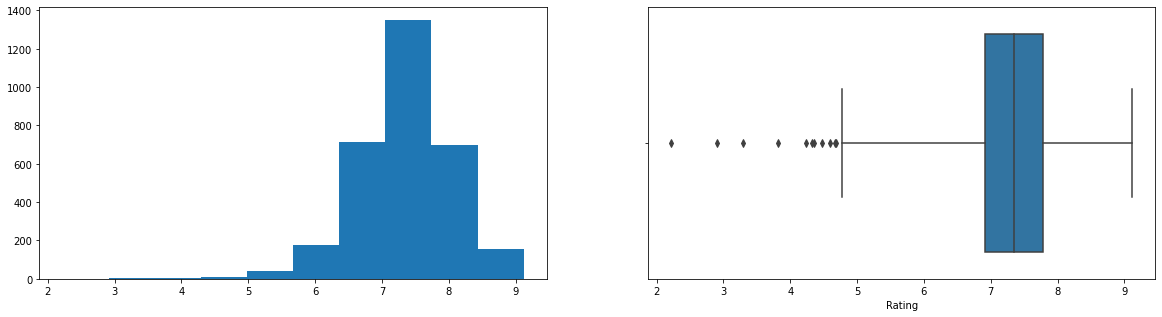

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Project/Anime Rating/fixed_anime_list.csv') #amit path
df_numeric = pd.read_csv('/content/drive/MyDrive/Project Anime Rating/fixed_anime_list.csv') #roee path
df_cat = pd.read_csv('/content/drive/MyDrive/Project Anime Rating/fixed_anime_list_NotNumeric.csv')
fig , axes = plt.subplots(1,2 , figsize=(20,5))
sns.boxplot(df_numeric['Rating'] , whis=2.5)
axes[0].hist(df_numeric['Rating'])

In [ ]:
#finding the outliars
Q1 = np.percentile(df_numeric['Rating'] , 25)
Q3 = np.percentile(df_numeric['Rating'], 75)
IQR = Q3-Q1
outliar_rows = df_numeric[(df_numeric['Rating'] < Q1 - 2.5*IQR) | (df_numeric['Rating'] > Q3 + 2.5*IQR)]

outliar_rows



,Anime name,Type,Episodes,Source,Demographic,Duration,Age rating,Added to list members,Added to favorites members,Rating,Members that voted,Top Genres,Top Studios
1160,Pupa,4,12.0,5,4,48.0,3,179963.0,758.0,3.30,100036.0,7,180
1200,Boku no Pico,2,1.0,9,4,32.0,5,173792.0,211.0,4.24,119087.0,3,199
1648,Conception,4,12.0,3,4,276.0,2,115709.0,324.0,4.60,47427.0,4,77
2143,Ex-Arm,4,12.0,5,2,276.0,2,77307.0,45.0,2.91,40871.0,0,223
2294,Pico to Chico,2,1.0,9,4,36.0,5,69184.0,169.0,4.35,44911.0,3,199
2377,Pico x CoCo x Chico,2,1.0,9,4,35.0,5,64677.0,364.0,4.33,41754.0,3,199
2380,Gibiate,4,12.0,9,4,288.0,3,64553.0,802.0,3.81,22470.0,0,198
2382,Hametsu no Mars,2,1.0,12,4,19.0,3,64521.0,681.0,2.22,46865.0,14,225
2833,Yakusoku no Neverland: Michishirube,3,1.0,5,4,23.0,3,46704.0,66.0,4.69,23092.0,14,39
3009,Souryo to Majiwaru Shikiyoku no Yoru ni...,1,12.0,5,0,48.0,5,41775.0,30.0,4.67,16606.0,13,159


In [ ]:
#removing outliars:
df_numeric = df_numeric.drop(index=outliar_rows.index)
df_cat = df_cat.drop(index=outliar_rows.index)
df_numeric.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)
df_numeric.to_csv("anime_list_no_outliars.csv" , index=False)

#Correlation:
using the heatmap below we saw that many of the parameters are highly correlated to the rating.




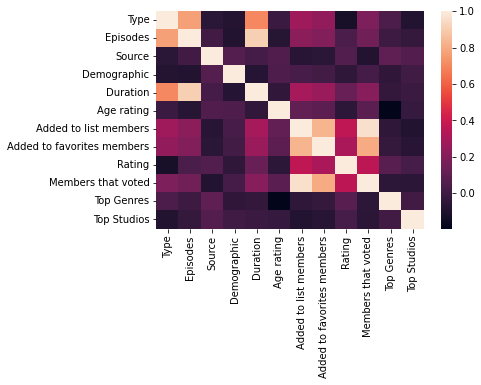

In [ ]:

sns.heatmap(df_numeric.corr("spearman"))

In [ ]:
df_numeric.corr("spearman")

,Type,Episodes,Source,Demographic,Duration,Age rating,Added to list members,Added to favorites members,Rating,Members that voted,Top Genres,Top Studios
Type,1.000000,0.768305,-0.059158,-0.080097,0.705832,-0.009028,0.277932,0.241585,-0.116895,0.188087,0.047355,-0.085891
Episodes,0.768305,1.000000,0.015795,-0.086214,0.907787,-0.070988,0.225049,0.202374,0.040359,0.151450,0.001927,-0.026377
Source,-0.059158,0.015795,1.000000,0.068243,0.024177,0.053686,-0.065095,-0.060805,0.062629,-0.083670,0.104068,0.062955
Demographic,-0.080097,-0.086214,0.068243,1.000000,-0.073603,0.051468,0.033254,0.019433,-0.046446,0.022932,-0.041763,0.011141
Duration,0.705832,0.907787,0.024177,-0.073603,1.000000,-0.035765,0.296564,0.263678,0.124209,0.216376,-0.032975,-0.009388
Age rating,-0.009028,-0.070988,0.053686,0.051468,-0.035765,1.000000,0.105884,0.091044,-0.052138,0.086462,-0.193613,-0.025546
Added to list members,0.277932,0.225049,-0.065095,0.033254,0.296564,0.105884,1.000000,0.830285,0.370403,0.966385,-0.046955,-0.082199
Added to favorites members,0.241585,0.202374,-0.060805,0.019433,0.263678,0.091044,0.830285,1.000000,0.310464,0.803659,-0.028645,-0.063435
Rating,-0.116895,0.040359,0.062629,-0.046446,0.124209,-0.052138,0.370403,0.310464,1.000000,0.365481,0.080015,0.025923
Members that voted,0.188087,0.151450,-0.083670,0.022932,0.216376,0.086462,0.966385,0.803659,0.365481,1.000000,-0.052432,-0.057895


#Graphs:

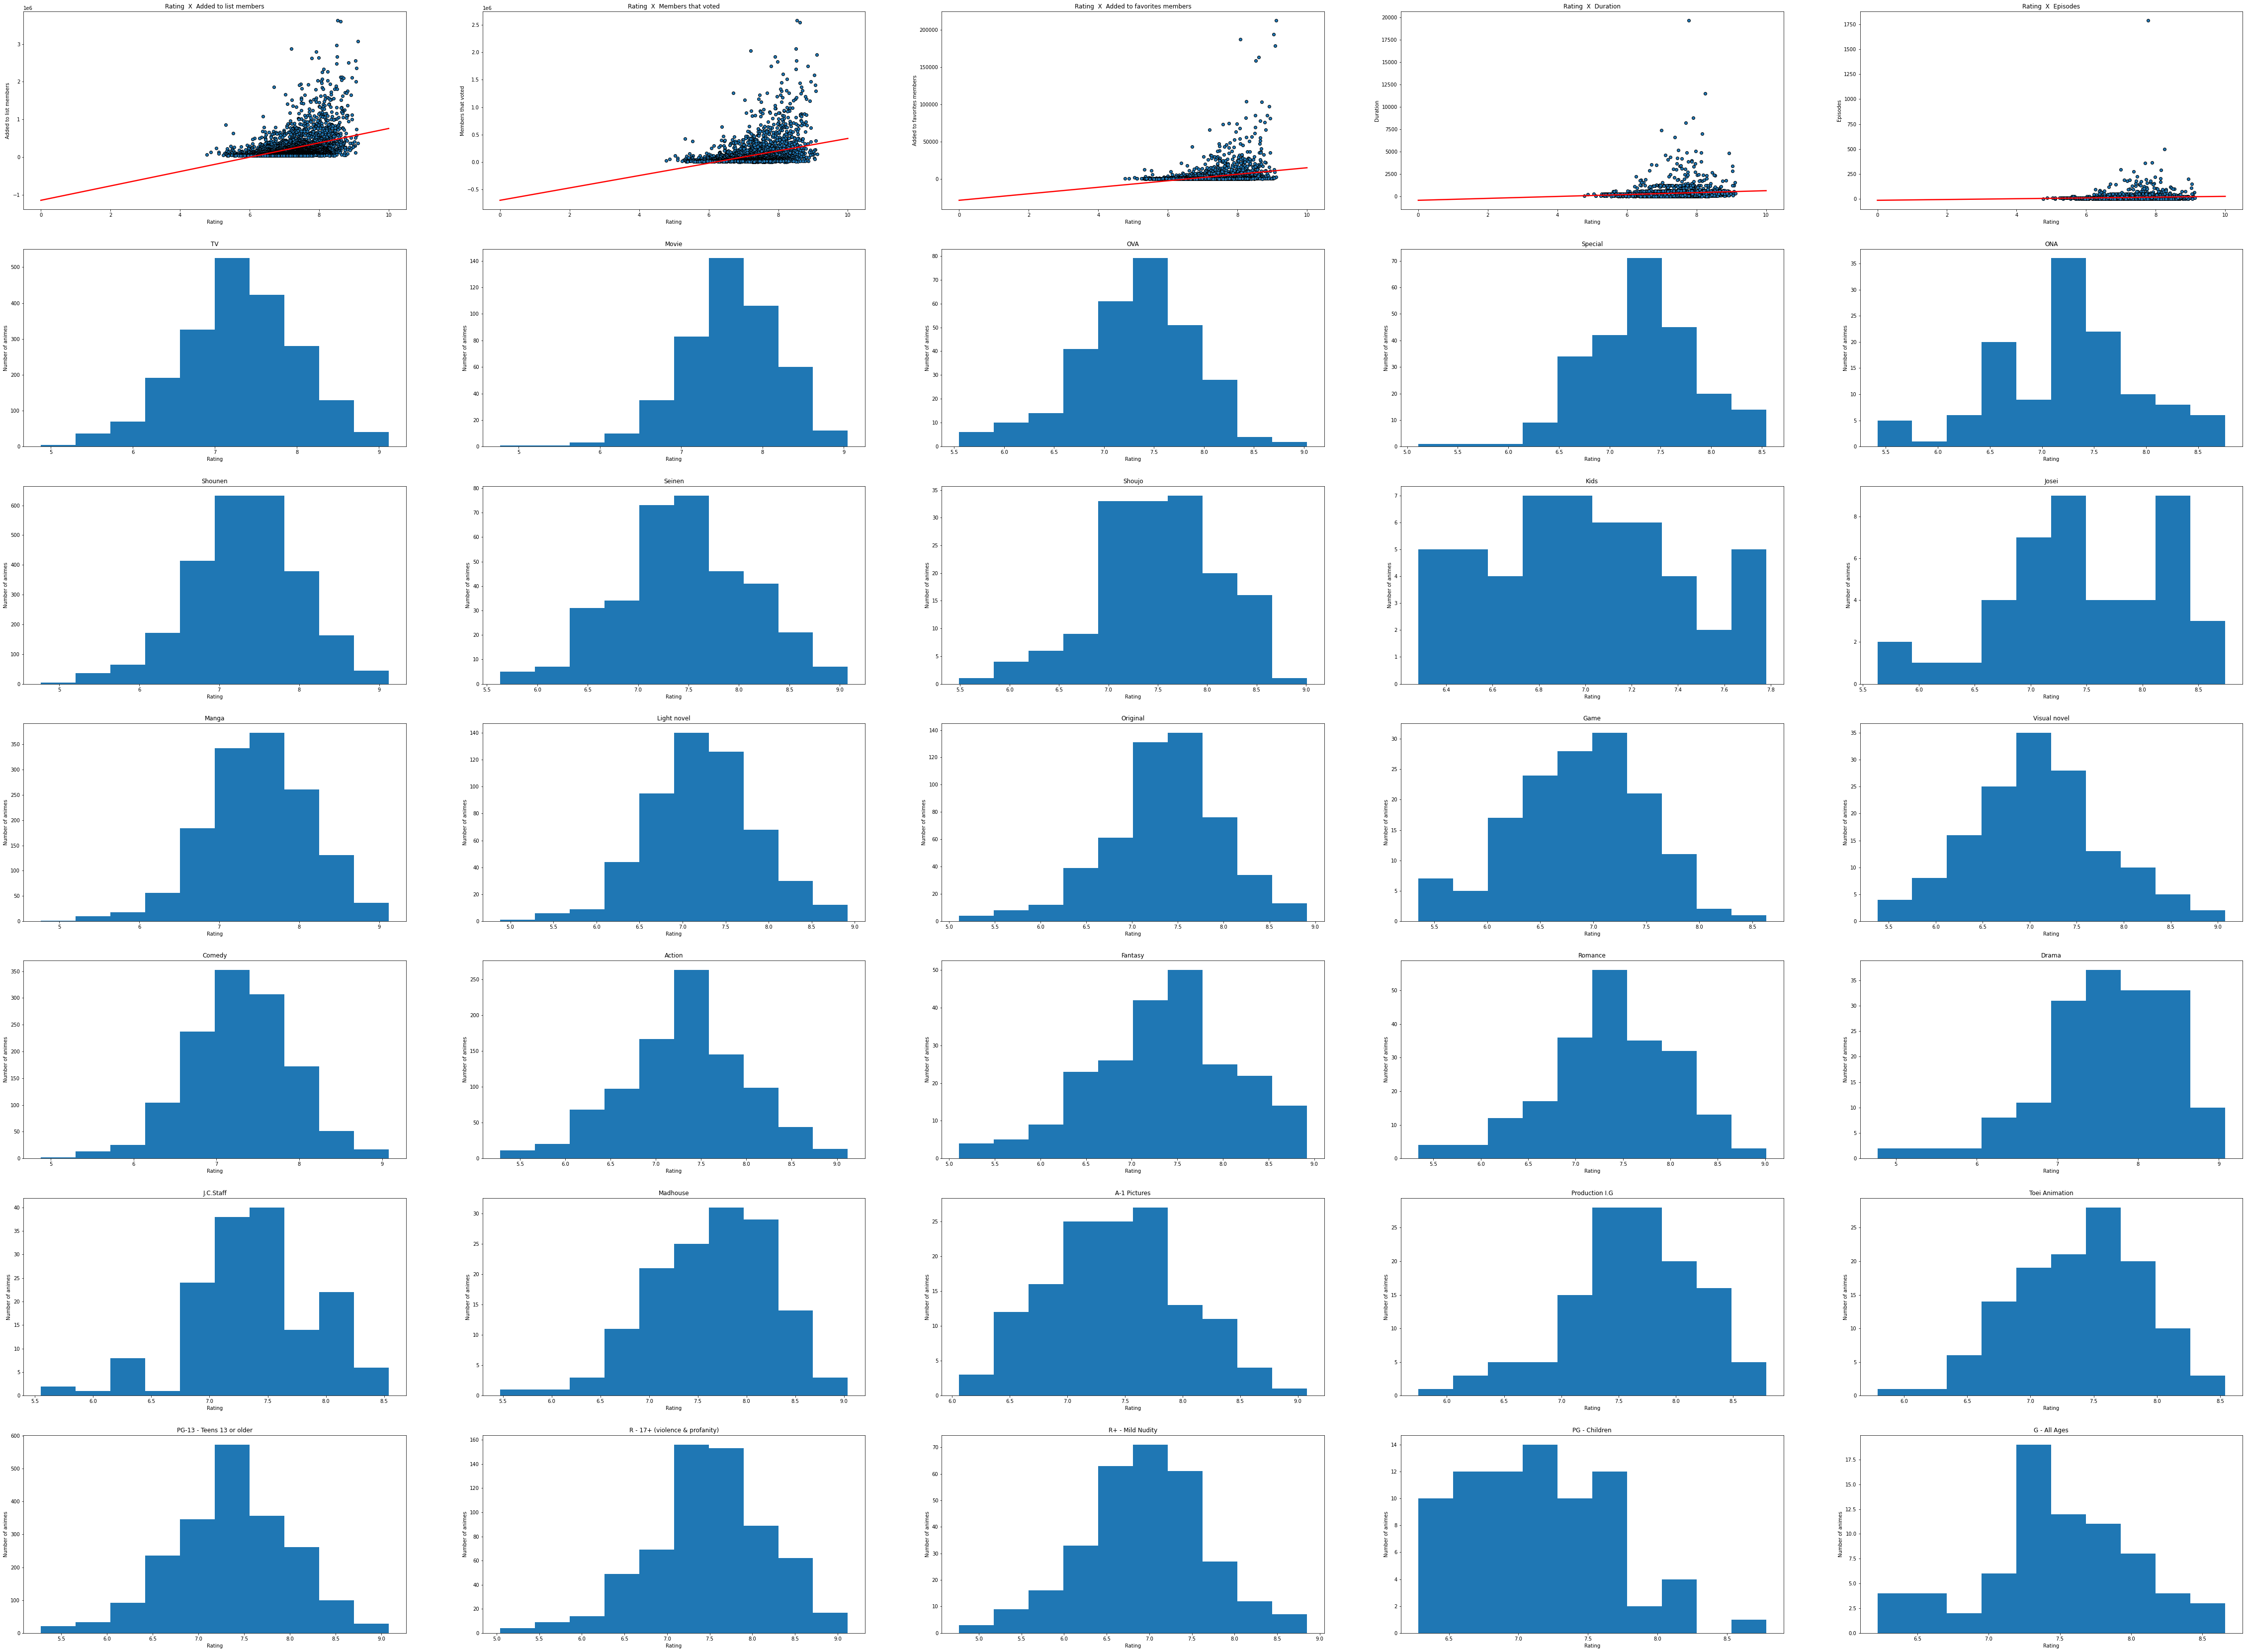

In [ ]:
#builds a scatter plot with regression line:
def scatter_creator(df,p1,p2,ax):
  ax.scatter(df[p1],df[p2], edgecolor="k")
  b, a = np.polyfit(df[p1], df[p2], deg=1)
  xseq = np.linspace(0, 10, num=100)
  ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
  ax.set_xlabel(p1)
  ax.set_ylabel(p2)
  ax.set_title(p1 + '  X  ' + p2)

#builds a histogram:
def hist_creator(df,p1,p2,line,ax):
  top_values=df[p2].value_counts().index
  for i in range(5):
    ax[line,i].hist(df[df[p2] == top_values[i]][p1])
    ax[line,i].set_xlabel(p1)
    ax[line,i].set_ylabel('Number of animes')
    ax[line,i].set_title(top_values[i])

fig , axes = plt.subplots(7,5 , figsize=(80,60))
scatter_creator(df_numeric,'Rating', 'Added to list members',axes[0,0])
scatter_creator(df_numeric,'Rating', 'Members that voted',axes[0,1])
scatter_creator(df_numeric,'Rating', 'Added to favorites members',axes[0,2])
scatter_creator(df_numeric,'Rating', 'Duration',axes[0,3])
scatter_creator(df_numeric,'Rating', 'Episodes',axes[0,4])
hist_creator(df_cat,'Rating','Type',1,axes)
hist_creator(df_cat,'Rating','Demographic',2,axes)
hist_creator(df_cat,'Rating','Source',3,axes)
hist_creator(df_cat,'Rating','Top Genres',4,axes)
hist_creator(df_cat,'Rating','Top Studios',5,axes)
hist_creator(df_cat,'Rating','Age rating',6,axes)


# sns.pairplot(df2[['Rating' , 'Added to list members' , 'Added to favorites members' , 'Members that voted' , 'Duration']])

# sns.boxplot(df2['Members that voted'], whis=3)


 

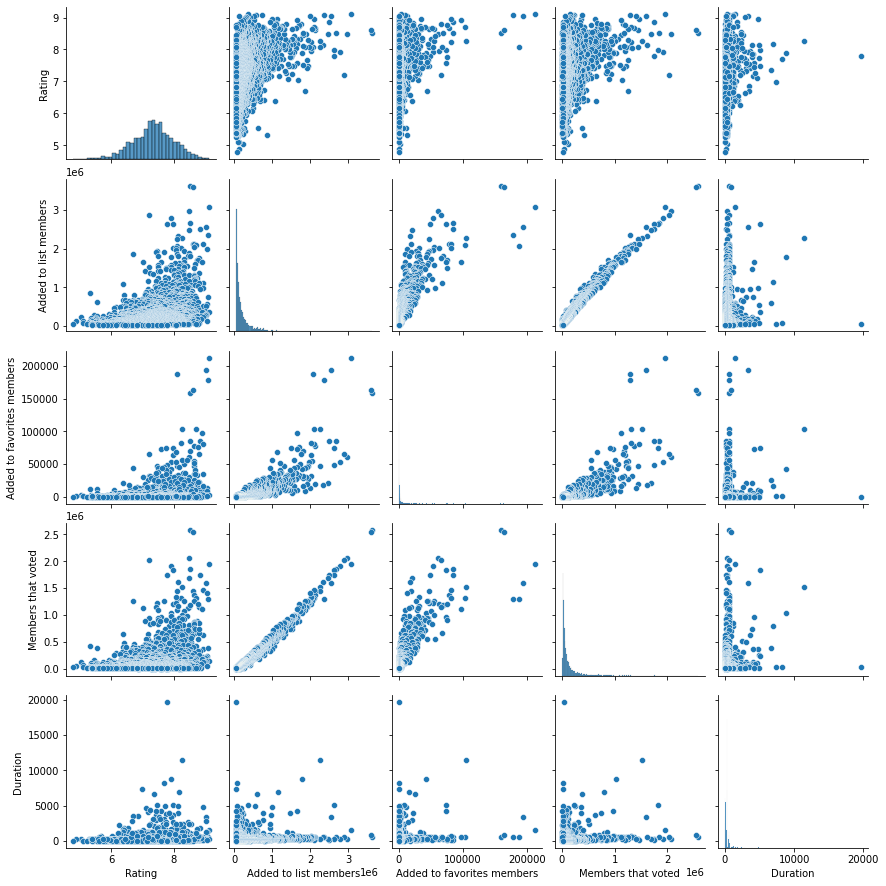

In [ ]:
sns.pairplot(df_numeric[['Rating' , 'Added to list members' , 'Added to favorites members' , 'Members that voted' , 'Duration']])

#**Mechine learning**:
---
We used supervised mechine learning to see if we can predict good animes based on parameters. We needed to divide the animes into rating classes and also the other משתנים רציפים.



*   class 1: 4.75 - 5.5 (very poor rating)
*   class 2:  5.5 - 6.25 (poor rating)
*   class 3: 6.25 - 7 (below average rating)
*   class 4: 7 - 7.75 (average rating)
*   class 5: 7.75 - 8.5 (good rating)
*   class 6: 8.5 - 9.25 (very good rating)




In [128]:
df_numeric = pd.read_csv('/content/drive/MyDrive/Project Anime Rating/anime_list_no_outliars.csv') #roee path
for i in range(df_numeric.shape[0]):
  r = df_numeric.at[i,'Rating']
  if( r<= 5.5):
    df_numeric.at[i,'Rating Class'] = 1
  if(r >= 5.5 and r<= 6.25):
    df_numeric.at[i,'Rating Class'] = 2
  if(r >= 6.25 and r<= 7):
    df_numeric.at[i,'Rating Class'] = 3
  if(r >= 7 and r<= 7.75):
    df_numeric.at[i,'Rating Class'] = 4
  if(r >= 7.75 and r<= 8.5):
    df_numeric.at[i,'Rating Class'] = 5
  if(r >= 8.5 and r<= 9.25):
    df_numeric.at[i,'Rating Class'] = 6

for i in range(df_numeric.shape[0]):
  r = df_numeric.at[i,'Episodes']
  if(r == 1):
    df_numeric.at[i,'Episodes Class'] = 1
  if(r > 1 and r<= 12):
    df_numeric.at[i,'Episodes Class'] = 2
  if(r > 12 and r<= 25):
    df_numeric.at[i,'Episodes Class'] = 3
  if(r > 25 and r<= 100):
    df_numeric.at[i,'Episodes Class'] = 4
  if(r > 100):
    df_numeric.at[i,'Episodes Class'] = 5



In [129]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    y = dataset[label_column].copy()
    X = dataset.drop(label_column , axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rand_state, test_size=test_ratio)
    return X_train, X_test, y_train, y_test

In [ ]:
#Naive bayes model:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_train = gnb.predict(X_train)
y_predicted = gnb.predict(X_test)
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_predicted))

Accuracy on training data =  0.21761658031088082
Accuracy on test data =  0.2356687898089172


In [172]:
def model_testing(df,y,model_name,features):
  X_train, X_test, y_train, y_test = split_to_train_and_test(df[features], y, 0.2, 42)
  if(model_name == 'KNN'):
    parameters = {'n_neighbors':range(1,56) }
    model = KNeighborsClassifier()
  if(model_name == 'Decision tree'):
    parameters = {'max_depth':range(1,30),"min_samples_split":range(20,100,5) }
    model = tree.DecisionTreeClassifier()
  if(model_name == 'Random tree'):
    parameters = {'n_estimators':range(50,551,100) }
    model = RandomForestClassifier()
  if(model_name == 'MLP'):
    parameters = {'max_iter':range(50,300,10) }
    model = MLPClassifier()
  clf = GridSearchCV(model, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
  clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  y_predicted = clf.predict(X_test)
  print("--------------------------------------------")
  print(model_name)
  print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
  print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
  print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_predicted))
  print("--------------------------------------------")




In [158]:
#1st models:
f = ['Type',	'Source',	'Demographic','Duration',	'Age rating',	'Added to list members','Added to favorites members','Members that voted',	
              'Top Genres',	'Top Studios','Rating Class','Episodes Class']
# model_testing(df_numeric,'Rating Class','KNN',f)
# model_testing(df_numeric,'Rating Class','Decision tree',f)
model_testing(df_numeric,'Rating Class','Random tree',f)
# model_testing(df_numeric,'Rating Class','MLP',f)

--------------------------------------------
Random tree
best parameter set is: {'n_estimators': 150}  and its score was 0.5181294780956016
Accuracy on training data =  1.0
Accuracy on test data =  0.5207006369426752
--------------------------------------------


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(50, 551, 100)},
             scoring=make_scorer(accuracy_score))

In [171]:
# df_numeric["list add / voting"] = df_numeric['Added to list members']+df_numeric['Members that voted']
# df_numeric["favorites / voting"] = df_numeric['Added to favorites members']+df_numeric['Members that voted']
# df_numeric["favorites / list add"] = df_numeric['Added to favorites members']+df_numeric['Added to list members']
f = ['Type',	'Source',	'Demographic','Duration',	'Age rating',	'Added to list members','Added to favorites members','Members that voted',	
              'Top Genres',	'Top Studios','Rating Class','Episodes Class','favorites / voting' , 'list add / voting']
df_numeric['Added to list members'] = df_numeric['Added to list members'] /df_numeric['Added to list members'].abs().max()
df_numeric['Duration'] = df_numeric['Duration'] /df_numeric['Duration'].abs().max()
df_numeric['Added to favorites members'] = df_numeric['Added to favorites members'] /df_numeric['Added to favorites members'].abs().max()
df_numeric['Members that voted'] = df_numeric['Members that voted'] /df_numeric['Members that voted'].abs().max()
model_testing(df_numeric,'Rating Class','Random tree',f)

--------------------------------------------
Random tree
best parameter set is: {'n_estimators': 450}  and its score was 0.5121462254773321
Accuracy on training data =  1.0
Accuracy on test data =  0.5222929936305732
--------------------------------------------


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(50, 551, 100)},
             scoring=make_scorer(accuracy_score))

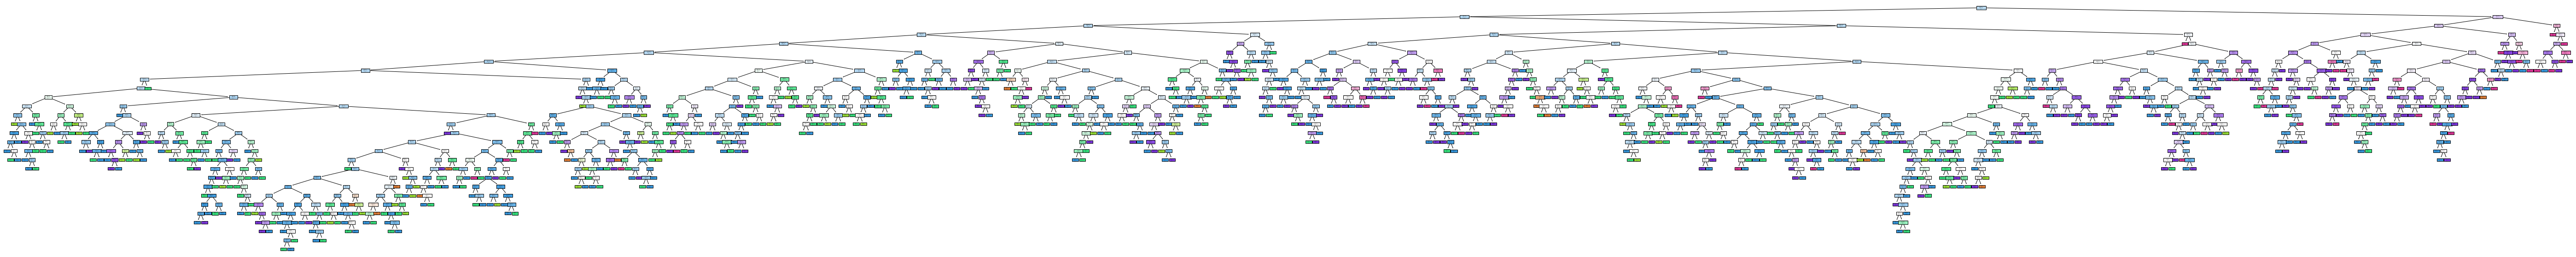

In [159]:
model = RandomForestClassifier(n_estimators=350)
X_train, X_test, y_train, y_test = split_to_train_and_test(df_numeric[f], 'Rating Class', 0.2, 42)
model.fit(X_train,y_train)
estimator = model.estimators_[5]
fig ,axes = plt.subplots(1,1,figsize = (100,10))
axes = tree.plot_tree(estimator, feature_names= f ,class_names='Rating Class',filled=True)

In [166]:
df_numeric2 = df_numeric
for i in range(df_numeric.shape[0]):
  r = df_numeric2.at[i,'Rating']
  if( r<= 7.5):
    df_numeric2.at[i,'Rating Class2'] = 1
  if(r >= 7.5 and r<= 8):
    df_numeric2.at[i,'Rating Class2'] = 2
  if(r >= 8):
    df_numeric2.at[i,'Rating Class2'] = 3



In [167]:
#1st models:
f = ['Type',	'Source',	'Demographic','Duration',	'Age rating',	'Added to list members','Added to favorites members','Members that voted',	
              'Top Genres',	'Top Studios','Rating Class2','Episodes Class']
model_testing(df_numeric2,'Rating Class2','KNN',f)
model_testing(df_numeric2,'Rating Class2','Decision tree',f)
model_testing(df_numeric2,'Rating Class2','Random tree',f)
model_testing(df_numeric2,'Rating Class2','MLP',f)

--------------------------------------------
KNN
best parameter set is: {'n_neighbors': 51}  and its score was 0.6281341699071976
Accuracy on training data =  0.629732961339179
Accuracy on test data =  0.6114649681528662
--------------------------------------------
--------------------------------------------
Decision tree
best parameter set is: {'max_depth': 6, 'min_samples_split': 55}  and its score was 0.6289341635454191
Accuracy on training data =  0.6819449980071741
Accuracy on test data =  0.6050955414012739
--------------------------------------------
--------------------------------------------
Random tree
best parameter set is: {'n_estimators': 250}  and its score was 0.6580265763294129
Accuracy on training data =  1.0
Accuracy on test data =  0.6353503184713376
--------------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


--------------------------------------------
MLP
best parameter set is: {'max_iter': 200}  and its score was 0.5866641219552926
Accuracy on training data =  0.2495017935432443
Accuracy on test data =  0.24203821656050956
--------------------------------------------


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'max_iter': range(50, 300, 10)},
             scoring=make_scorer(accuracy_score))